# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    data_transform = transforms.Compose([transforms.Resize(image_size),
                                         transforms.ToTensor()])
#                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    data = datasets.ImageFolder(data_dir,transform=data_transform)
    
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 50
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

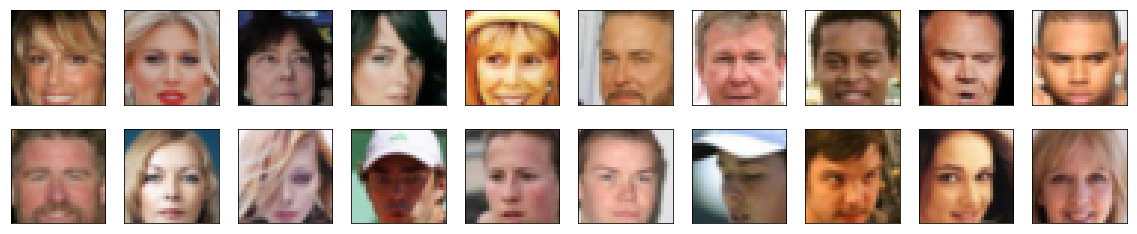

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    range_min = feature_range[0]
    range_max = feature_range[1]
    
    x = (x - 0.5)*(range_max-range_min)

    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8353)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def make_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def make_deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(t_conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Def Convolutional Layers
        # 32 x 32 --> 16 x 16
        self.conv_set1 = make_conv(in_channels=3, out_channels=conv_dim,
                                   kernel_size=4, stride=2, padding=1, batch_norm=False)
        # 16 x 16 --> 8 x 8
        self.conv_set2 = make_conv(in_channels=conv_dim, out_channels=conv_dim*2,
                                   kernel_size=4, stride=2, padding=1, batch_norm=True)
        # 8 x 8 --> 4 x 4
        self.conv_set3 = make_conv(in_channels=conv_dim*2, out_channels=conv_dim*4,
                                   kernel_size=4, stride=2, padding=1, batch_norm=True)
        # 4 x 4 --> Fully Connected Layer      
        # Define fully connected layer
        self.fcl = nn.Linear(in_features=conv_dim*4*4*4,
                             out_features=1)
        # Leaky RELU
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.leaky_relu(self.conv_set1(x))
        x = self.leaky_relu(self.conv_set2(x))
        x = self.leaky_relu(self.conv_set3(x))
        x = x.view(-1,self.conv_dim*4*4*4)
        x = self.fcl(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.input_size = z_size
        self.conv_dim = conv_dim
        
        # Define layers
        self.fcl = nn.Linear(in_features=self.input_size, out_features=(conv_dim*4*4*4))
        # 4 x 4 --> 8 x 8
        self.t_convset1 = make_deconv(in_channels=conv_dim*4, out_channels=conv_dim*2,
                                      kernel_size=4, stride=2, padding=1, batch_norm=True)
        # 8 x 8 --> 16 x 16
        self.t_convset2 = make_deconv(in_channels=conv_dim*2, out_channels=conv_dim,
                                      kernel_size=4, stride=2, padding=1, batch_norm=True)
        # 16 x 16 --> 32 x 32
        self.t_convset3 = make_deconv(in_channels=conv_dim, out_channels=3,
                                      kernel_size=4, stride=2, padding=1, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fcl(x)
        x = x.view(-1,self.conv_dim*4,4,4)
        x = F.relu(self.t_convset1(x))
        x = F.relu(self.t_convset2(x))
        x = F.tanh(self.t_convset3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_set1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv_set2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_set3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fcl): Linear(in_features=4096, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fcl): Linear(in_features=100, out_features=4096, bias=True)
  (t_convset1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_convset2): Sequential(
    (0): ConvTran

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            # generate fake images
            latent_vec = np.random.uniform(-1, 1, size=(batch_size, z_size))
            latent_vec = torch.from_numpy(latent_vec).float()
            
            if train_on_gpu:
                latent_vec = latent_vec.cuda()
                real_images = real_images.cuda()
            fake_images = G(latent_vec)
            
            d_loss = real_loss(D(real_images)) + fake_loss(D(fake_images))
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            # generate more fake images
            latent_vec = np.random.uniform(-1, 1, size=(batch_size, z_size))
            latent_vec = torch.from_numpy(latent_vec).float()
            
            if train_on_gpu:
                latent_vec = latent_vec.cuda()
            fake_images = G(latent_vec)
            
            g_loss = real_loss(D(fake_images))
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
from workspace_utils import active_session

with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 1.7362 | g_loss: 1.1166
Epoch [    1/   40] | d_loss: 0.5431 | g_loss: 3.3641
Epoch [    1/   40] | d_loss: 0.5319 | g_loss: 2.9797
Epoch [    1/   40] | d_loss: 0.4987 | g_loss: 3.2913
Epoch [    1/   40] | d_loss: 0.6041 | g_loss: 2.1472
Epoch [    1/   40] | d_loss: 1.0646 | g_loss: 0.7331
Epoch [    1/   40] | d_loss: 0.9970 | g_loss: 2.9219
Epoch [    1/   40] | d_loss: 1.0071 | g_loss: 2.4455
Epoch [    1/   40] | d_loss: 0.8337 | g_loss: 1.9645
Epoch [    1/   40] | d_loss: 0.9510 | g_loss: 3.3686
Epoch [    1/   40] | d_loss: 0.8484 | g_loss: 2.8628
Epoch [    1/   40] | d_loss: 0.8414 | g_loss: 2.3892
Epoch [    1/   40] | d_loss: 1.0795 | g_loss: 1.2020
Epoch [    1/   40] | d_loss: 1.0651 | g_loss: 1.7676
Epoch [    1/   40] | d_loss: 0.8152 | g_loss: 2.1607
Epoch [    1/   40] | d_loss: 0.8092 | g_loss: 1.5254
Epoch [    1/   40] | d_loss: 1.0059 | g_loss: 1.3444
Epoch [    1/   40] | d_loss: 1.3397 | g_loss: 0.9381
Epoch [    1/   40] | d_loss

Epoch [    5/   40] | d_loss: 0.9709 | g_loss: 1.9689
Epoch [    5/   40] | d_loss: 1.1442 | g_loss: 1.1749
Epoch [    5/   40] | d_loss: 0.9941 | g_loss: 1.2818
Epoch [    5/   40] | d_loss: 1.0157 | g_loss: 2.2464
Epoch [    5/   40] | d_loss: 0.9261 | g_loss: 1.2257
Epoch [    5/   40] | d_loss: 1.0551 | g_loss: 1.2785
Epoch [    5/   40] | d_loss: 1.1408 | g_loss: 1.7120
Epoch [    5/   40] | d_loss: 0.9837 | g_loss: 1.4867
Epoch [    5/   40] | d_loss: 0.9572 | g_loss: 1.3498
Epoch [    5/   40] | d_loss: 1.0405 | g_loss: 1.5211
Epoch [    5/   40] | d_loss: 1.1132 | g_loss: 1.1532
Epoch [    5/   40] | d_loss: 1.2720 | g_loss: 2.4929
Epoch [    5/   40] | d_loss: 0.8926 | g_loss: 1.8338
Epoch [    5/   40] | d_loss: 1.0193 | g_loss: 1.9343
Epoch [    5/   40] | d_loss: 1.2064 | g_loss: 2.6873
Epoch [    5/   40] | d_loss: 1.1045 | g_loss: 1.5210
Epoch [    5/   40] | d_loss: 1.1073 | g_loss: 1.4059
Epoch [    5/   40] | d_loss: 0.9732 | g_loss: 1.6256
Epoch [    5/   40] | d_loss

Epoch [    9/   40] | d_loss: 0.8667 | g_loss: 1.2122
Epoch [    9/   40] | d_loss: 0.7342 | g_loss: 1.5525
Epoch [    9/   40] | d_loss: 0.7000 | g_loss: 1.8626
Epoch [    9/   40] | d_loss: 0.8023 | g_loss: 2.5013
Epoch [    9/   40] | d_loss: 0.9840 | g_loss: 1.1704
Epoch [    9/   40] | d_loss: 0.8357 | g_loss: 1.8167
Epoch [    9/   40] | d_loss: 0.7392 | g_loss: 1.8190
Epoch [    9/   40] | d_loss: 1.0685 | g_loss: 1.3747
Epoch [    9/   40] | d_loss: 0.5616 | g_loss: 1.9967
Epoch [    9/   40] | d_loss: 1.0421 | g_loss: 1.6410
Epoch [    9/   40] | d_loss: 0.7771 | g_loss: 1.2866
Epoch [    9/   40] | d_loss: 0.9154 | g_loss: 1.5387
Epoch [    9/   40] | d_loss: 1.1984 | g_loss: 0.9839
Epoch [    9/   40] | d_loss: 0.8868 | g_loss: 2.1027
Epoch [    9/   40] | d_loss: 0.8139 | g_loss: 0.9944
Epoch [    9/   40] | d_loss: 0.7580 | g_loss: 1.9431
Epoch [    9/   40] | d_loss: 0.8624 | g_loss: 1.9611
Epoch [    9/   40] | d_loss: 0.7603 | g_loss: 2.0662
Epoch [    9/   40] | d_loss

Epoch [   14/   40] | d_loss: 0.5720 | g_loss: 2.0080
Epoch [   14/   40] | d_loss: 0.5677 | g_loss: 2.6802
Epoch [   14/   40] | d_loss: 0.8452 | g_loss: 2.8623
Epoch [   14/   40] | d_loss: 0.5336 | g_loss: 2.8233
Epoch [   14/   40] | d_loss: 0.5764 | g_loss: 2.1180
Epoch [   14/   40] | d_loss: 0.8168 | g_loss: 1.3274
Epoch [   14/   40] | d_loss: 0.5257 | g_loss: 3.0759
Epoch [   14/   40] | d_loss: 0.8639 | g_loss: 2.3996
Epoch [   14/   40] | d_loss: 0.5137 | g_loss: 2.6946
Epoch [   14/   40] | d_loss: 0.7757 | g_loss: 1.9830
Epoch [   14/   40] | d_loss: 0.8146 | g_loss: 2.3607
Epoch [   14/   40] | d_loss: 0.7310 | g_loss: 1.7586
Epoch [   15/   40] | d_loss: 0.5359 | g_loss: 2.4038
Epoch [   15/   40] | d_loss: 0.7907 | g_loss: 1.7445
Epoch [   15/   40] | d_loss: 0.6570 | g_loss: 1.5126
Epoch [   15/   40] | d_loss: 0.8216 | g_loss: 1.9954
Epoch [   15/   40] | d_loss: 0.6478 | g_loss: 2.9860
Epoch [   15/   40] | d_loss: 0.8284 | g_loss: 2.5730
Epoch [   15/   40] | d_loss

Epoch [   18/   40] | d_loss: 0.4421 | g_loss: 3.4141
Epoch [   18/   40] | d_loss: 0.9437 | g_loss: 3.0940
Epoch [   18/   40] | d_loss: 0.5658 | g_loss: 3.0101
Epoch [   18/   40] | d_loss: 0.5588 | g_loss: 3.0065
Epoch [   19/   40] | d_loss: 0.5943 | g_loss: 3.2845
Epoch [   19/   40] | d_loss: 0.4891 | g_loss: 2.8278
Epoch [   19/   40] | d_loss: 0.5220 | g_loss: 2.1147
Epoch [   19/   40] | d_loss: 0.5071 | g_loss: 2.6022
Epoch [   19/   40] | d_loss: 0.4470 | g_loss: 3.0430
Epoch [   19/   40] | d_loss: 1.0401 | g_loss: 2.6408
Epoch [   19/   40] | d_loss: 0.4843 | g_loss: 2.8672
Epoch [   19/   40] | d_loss: 0.4952 | g_loss: 2.5538
Epoch [   19/   40] | d_loss: 0.4338 | g_loss: 3.2685
Epoch [   19/   40] | d_loss: 0.6557 | g_loss: 1.7488
Epoch [   19/   40] | d_loss: 0.7647 | g_loss: 1.6948
Epoch [   19/   40] | d_loss: 0.5289 | g_loss: 3.1415
Epoch [   19/   40] | d_loss: 0.4881 | g_loss: 2.8944
Epoch [   19/   40] | d_loss: 0.4724 | g_loss: 2.9187
Epoch [   19/   40] | d_loss

Epoch [   23/   40] | d_loss: 0.5025 | g_loss: 3.5655
Epoch [   23/   40] | d_loss: 0.4476 | g_loss: 2.1070
Epoch [   23/   40] | d_loss: 0.4370 | g_loss: 3.1293
Epoch [   23/   40] | d_loss: 1.5260 | g_loss: 0.7554
Epoch [   23/   40] | d_loss: 0.6103 | g_loss: 2.1805
Epoch [   23/   40] | d_loss: 0.4682 | g_loss: 3.6984
Epoch [   23/   40] | d_loss: 0.6506 | g_loss: 1.7544
Epoch [   23/   40] | d_loss: 0.4768 | g_loss: 2.7601
Epoch [   23/   40] | d_loss: 0.6772 | g_loss: 2.3781
Epoch [   23/   40] | d_loss: 0.4458 | g_loss: 3.9519
Epoch [   23/   40] | d_loss: 0.4107 | g_loss: 3.6801
Epoch [   23/   40] | d_loss: 0.5195 | g_loss: 2.0479
Epoch [   23/   40] | d_loss: 0.5473 | g_loss: 2.9228
Epoch [   23/   40] | d_loss: 0.6832 | g_loss: 4.7537
Epoch [   23/   40] | d_loss: 0.4082 | g_loss: 3.0728
Epoch [   23/   40] | d_loss: 0.4932 | g_loss: 2.8005
Epoch [   23/   40] | d_loss: 0.5578 | g_loss: 2.9226
Epoch [   23/   40] | d_loss: 0.4194 | g_loss: 3.6656
Epoch [   23/   40] | d_loss

Epoch [   27/   40] | d_loss: 0.4430 | g_loss: 3.4530
Epoch [   27/   40] | d_loss: 0.8152 | g_loss: 1.2527
Epoch [   27/   40] | d_loss: 0.4789 | g_loss: 2.9281
Epoch [   27/   40] | d_loss: 0.4554 | g_loss: 2.1432
Epoch [   27/   40] | d_loss: 0.4536 | g_loss: 3.4734
Epoch [   27/   40] | d_loss: 0.4246 | g_loss: 2.5252
Epoch [   27/   40] | d_loss: 0.4215 | g_loss: 3.4661
Epoch [   27/   40] | d_loss: 0.4187 | g_loss: 3.7321
Epoch [   27/   40] | d_loss: 0.4063 | g_loss: 3.7079
Epoch [   27/   40] | d_loss: 0.4954 | g_loss: 2.0571
Epoch [   27/   40] | d_loss: 0.7727 | g_loss: 3.9687
Epoch [   27/   40] | d_loss: 0.4142 | g_loss: 3.8043
Epoch [   27/   40] | d_loss: 0.4341 | g_loss: 2.8428
Epoch [   27/   40] | d_loss: 0.4306 | g_loss: 2.7013
Epoch [   27/   40] | d_loss: 0.4143 | g_loss: 3.1788
Epoch [   27/   40] | d_loss: 0.5130 | g_loss: 3.2819
Epoch [   27/   40] | d_loss: 0.6088 | g_loss: 2.6066
Epoch [   27/   40] | d_loss: 0.6415 | g_loss: 2.9951
Epoch [   27/   40] | d_loss

Epoch [   32/   40] | d_loss: 0.4374 | g_loss: 2.7453
Epoch [   32/   40] | d_loss: 0.4069 | g_loss: 3.9901
Epoch [   32/   40] | d_loss: 0.4832 | g_loss: 2.9977
Epoch [   32/   40] | d_loss: 0.4450 | g_loss: 1.9990
Epoch [   32/   40] | d_loss: 0.4703 | g_loss: 3.7182
Epoch [   32/   40] | d_loss: 0.4488 | g_loss: 2.9431
Epoch [   32/   40] | d_loss: 0.4153 | g_loss: 3.6643
Epoch [   32/   40] | d_loss: 0.6777 | g_loss: 3.2204
Epoch [   32/   40] | d_loss: 0.4119 | g_loss: 3.8383
Epoch [   32/   40] | d_loss: 0.7689 | g_loss: 1.5142
Epoch [   32/   40] | d_loss: 0.5683 | g_loss: 2.4732
Epoch [   32/   40] | d_loss: 0.4513 | g_loss: 3.2638
Epoch [   32/   40] | d_loss: 0.3976 | g_loss: 3.2538
Epoch [   32/   40] | d_loss: 0.4506 | g_loss: 3.0134
Epoch [   32/   40] | d_loss: 0.4623 | g_loss: 3.5620
Epoch [   32/   40] | d_loss: 0.4384 | g_loss: 3.6540
Epoch [   32/   40] | d_loss: 0.7210 | g_loss: 2.0423
Epoch [   32/   40] | d_loss: 0.4142 | g_loss: 3.2329
Epoch [   32/   40] | d_loss

Epoch [   36/   40] | d_loss: 0.4111 | g_loss: 3.2198
Epoch [   36/   40] | d_loss: 0.5429 | g_loss: 2.6832
Epoch [   36/   40] | d_loss: 0.4923 | g_loss: 3.7868
Epoch [   36/   40] | d_loss: 0.4044 | g_loss: 4.1015
Epoch [   36/   40] | d_loss: 0.4338 | g_loss: 3.9274
Epoch [   36/   40] | d_loss: 0.4309 | g_loss: 3.2141
Epoch [   36/   40] | d_loss: 0.4717 | g_loss: 4.0671
Epoch [   36/   40] | d_loss: 0.4986 | g_loss: 3.1557
Epoch [   36/   40] | d_loss: 0.4005 | g_loss: 3.4944
Epoch [   36/   40] | d_loss: 0.4144 | g_loss: 3.7058
Epoch [   36/   40] | d_loss: 0.4367 | g_loss: 4.2188
Epoch [   36/   40] | d_loss: 0.4076 | g_loss: 3.1758
Epoch [   36/   40] | d_loss: 0.4526 | g_loss: 3.5548
Epoch [   36/   40] | d_loss: 0.4161 | g_loss: 2.8749
Epoch [   36/   40] | d_loss: 0.5947 | g_loss: 3.3847
Epoch [   37/   40] | d_loss: 0.4097 | g_loss: 3.3223
Epoch [   37/   40] | d_loss: 0.3971 | g_loss: 4.1599
Epoch [   37/   40] | d_loss: 0.7346 | g_loss: 2.0650
Epoch [   37/   40] | d_loss

Epoch [   40/   40] | d_loss: 0.3751 | g_loss: 3.3934
Epoch [   40/   40] | d_loss: 0.3984 | g_loss: 3.1592
Epoch [   40/   40] | d_loss: 0.3958 | g_loss: 4.2076
Epoch [   40/   40] | d_loss: 0.3812 | g_loss: 4.7695
Epoch [   40/   40] | d_loss: 0.4198 | g_loss: 4.0742
Epoch [   40/   40] | d_loss: 0.5369 | g_loss: 3.3590
Epoch [   40/   40] | d_loss: 0.4644 | g_loss: 2.5781


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

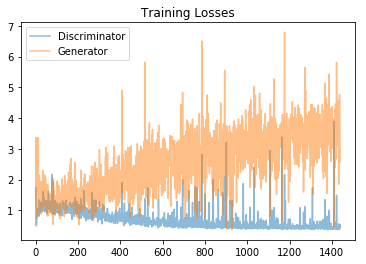

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

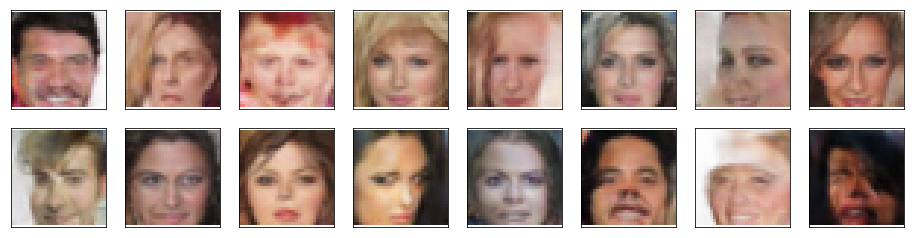

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

+ *Dataset Bias*: 
    + Because the input dataset does tend to have more white faces than faces with more pigmented skintones (especially black or brown), the generated faces almost all have have lighter pigmentation. To address this potential issue, future training sets may need to upsample the skintones that are less represented
+ *Model Size*: 
    + Images were rescaled to 32 x 32, which meant that alot of the more subtle detail and shadows were not well represented in the training data. 
    + Instances with hair covering portions of the face or headwear covering the top of the head proved problematic to the model. Perhaps with larger source images and a larger model, generated images could have been more realistic
    + The models defined above could have been configured to be even deeper. Deeper net might have been able to capture additional nuances of perspective shift. For instance, the generated faces tend to be "head on," and if the generated faces happened **not** to face the "camera" directly, they were simply had more distortions
+ *Optimization Strategy*:     
    + This model may have been able to train for a few more epochs, as discriminator loss was still decreasing (slowly) even at epoch 40
    + The trend of generator and discriminator losses above suggests that the discriminator began to "dominate" the training process, meaning it became so good at discerning real versus fake images that the generator images were nearly always correctly classified as "fake." Perhaps with a slower discriminator learning rate, the generator is better able to "keep up"


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.